<a href="https://colab.research.google.com/github/rahulrajpr/AdvancedHyperParameterOptimisation/blob/SearchAlgorithms/RandomisedSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
from sklearn.datasets import load_breast_cancer

In [45]:
dataset = load_breast_cancer()
data = dataset.data
target = dataset.target
columns = dataset.feature_names

In [46]:
df = pd.DataFrame(data = data, columns = columns)
df['target'] = target

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [48]:
X = df.drop('target', axis =1)
y = df['target']

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.7, random_state = 100, stratify = y)

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

creating the model object form gradient boosting classifier

In [52]:
gbc = GradientBoostingClassifier(random_state = 100)

Introducing scipy for generating distribitons

In [53]:
from scipy import stats

In [54]:
for i in range(10):
  print(stats.randint(10,120).rvs()) # return random integers within the given range

114
10
43
109
15
25
110
96
10
32


In [55]:
# retuns the distribition object of values
stats.randint(10,120)

In [56]:
for i in range(10):
  print(stats.uniform(0,1).rvs()) # return random floats within the given range

0.8101432618334691
0.26103948112081365
0.2325491951839852
0.6838567819963124
0.21803443072858708
0.9698195422624776
0.6186036500783063
0.9747400145515474
0.820953316810915
0.6085939305771998


In [57]:
# retuns the distribition object of values within the given range
stats.uniform(0,1)

creating the hyperparametes Space

In [58]:
params_dist = { 'n_estimators' : stats.randint(10,120),
          'min_samples_split' : stats.uniform(0,1),
          'max_depth' : stats.randint(1,5),
          'loss':['exponential','deviance']}

creating the randomised cv object

In [59]:
from sklearn.model_selection import RandomizedSearchCV

In [60]:
search = RandomizedSearchCV(estimator = gbc,
                            param_distributions= params_dist,
                            scoring = 'roc_auc',
                            n_iter = 60, # according to studies, 60 is the best iterations for random searches
                            cv = 5,
                            verbose = 1,
                            n_jobs = -1,)

In [61]:
search.fit(X_train,y_train)
%time

Fitting 5 folds for each of 60 candidates, totalling 300 fits
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


Extract the bets model and the parameters

In [65]:
search.best_params_

{'loss': 'exponential',
 'max_depth': 3,
 'min_samples_split': 0.6970128297599016,
 'n_estimators': 112}

In [66]:
best_estimator = search.best_estimator_

Evaluating the Model

In [62]:
from sklearn.metrics import roc_auc_score

In [67]:
print('roc auc in train set : ',roc_auc_score(y_train, best_estimator.predict(X_train)))
print('roc auc in test set : ',roc_auc_score(y_test, best_estimator.predict(X_test)))

roc auc in train set :  0.9966216216216216
roc auc in test set :  0.9594042056074766


Lets explore the best models returned by the randomised search cv

In [71]:
res = pd.DataFrame(search.cv_results_)

In [78]:
sel_cols = ['rank_test_score','mean_test_score','std_test_score', 'param_loss','param_n_estimators','param_min_samples_split','param_max_depth']

In [80]:
res = res.sort_values(by = 'mean_test_score', ascending = False)[sel_cols].set_index('rank_test_score')

In [83]:
res.head(10)

,mean_test_score,std_test_score,param_loss,param_n_estimators,param_min_samples_split,param_max_depth
rank_test_score,,,,,,
1,0.987090,0.008871,exponential,112,0.697013,3
2,0.986485,0.009718,exponential,100,0.637062,3
3,0.986182,0.008877,deviance,42,0.020075,3
4,0.986147,0.009558,exponential,62,0.510598,4
5,0.985894,0.011847,deviance,102,0.470415,3
5,0.985894,0.012408,exponential,84,0.066351,2
7,0.985779,0.011924,exponential,72,0.471985,4
8,0.985770,0.008262,exponential,64,0.712625,4
9,0.985756,0.012037,exponential,109,0.357618,3


In [99]:
def explore_parameter(parameter):
  mean = res.groupby(parameter)['mean_test_score'].mean()
  std = res.groupby(parameter)['mean_test_score'].std()
  mean.plot(yerr = [std,std])
  plt.show()

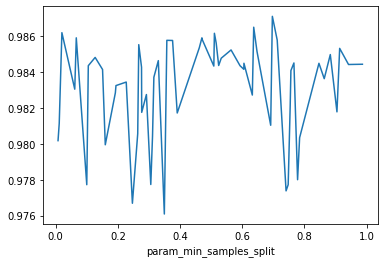

In [101]:
explore_parameter('param_min_samples_split')

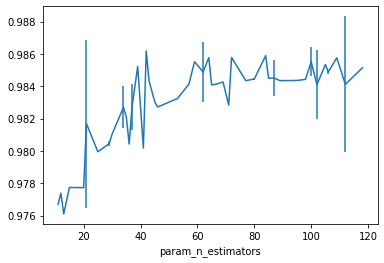

In [102]:
explore_parameter('param_n_estimators')

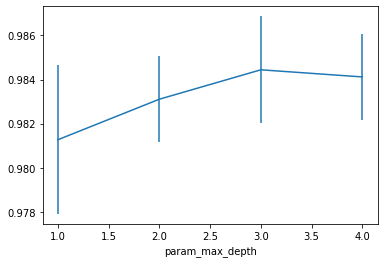

In [103]:
explore_parameter('param_max_depth')

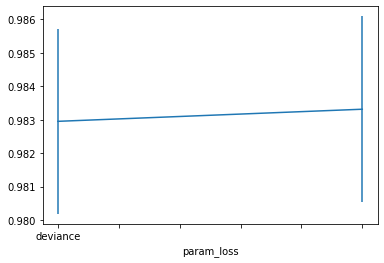

In [104]:
explore_parameter('param_loss')

End of the document